In [14]:
import subprocess
from matplotlib import pyplot as plt 
import numpy as np
import json 
batch_size = (1, 2, 4, 8, 16, 32, 64, 128, 256)
density = (0.7, 0.65, 0.6, 0.55, 0.5, 0.475, 0.45, 0.425, 0.4, 0.375, 0.35, 0.325, 0.3, 0.275, 0.25, 0.225, 0.2, 0.175, 0.15, 0.125, 0.1, 0.075, 0.05, 0.025, 0.02, 0.01, 0.00175, 0.0015, 0.001)
calculate_sparsity = lambda density: round((1 - density) * 100, 5)
sparsity = list(map(calculate_sparsity, density))
problem = {}
problem["qkv"] = (7680, 2560)
problem['attention_fc'] = (2560, 2560)
problem['linear1'] = (10240, 2560)
problem['linear2'] = (2560,10240)


#execution_time = {}
#compute_util = {}    

# for layer in problem:
#     execution_time[layer] = {}
#     compute_util[layer] = {}
#     for batch in batch_size:
#         execution_time[layer][batch] = {}
#         compute_util[layer][batch] = {}
#         for sparse in density:
#             execution_time[layer][batch][sparse] = 0
#             compute_util[layer][batch][sparse] = 0

In [15]:
import json

with open('./baseline2.json', 'r') as file:
    baseline = json.load(file, object_hook=lambda obj: {int(key) if key.isdigit() else key: value for key, value in obj.items()})
with open('./compute_util2.json', 'r') as file:
    compute_util = json.load(file, object_hook=lambda obj: {int(key) if key.isdigit() else key: value for key, value in obj.items()})
with open('./latency2.json', 'r') as file:
    execution_time = json.load(file, object_hook=lambda obj: {int(key) if key.isdigit() else key: value for key, value in obj.items()})

In [16]:
util_data = {}
lat_data = {}
for layer_type in problem:
    util_data[layer_type] = {}
    lat_data[layer_type] = {}
    for batch in batch_size:
        util_data[layer_type][batch] = []
        lat_data[layer_type][batch] = []
        for dense in compute_util[layer_type][batch]:
            util_data[layer_type][batch].append(compute_util[layer_type][batch][dense])
            lat_data[layer_type][batch].append(execution_time[layer_type][batch][dense])

In [ ]:
for i in baseline['compute']['qkv']:
    print(i)


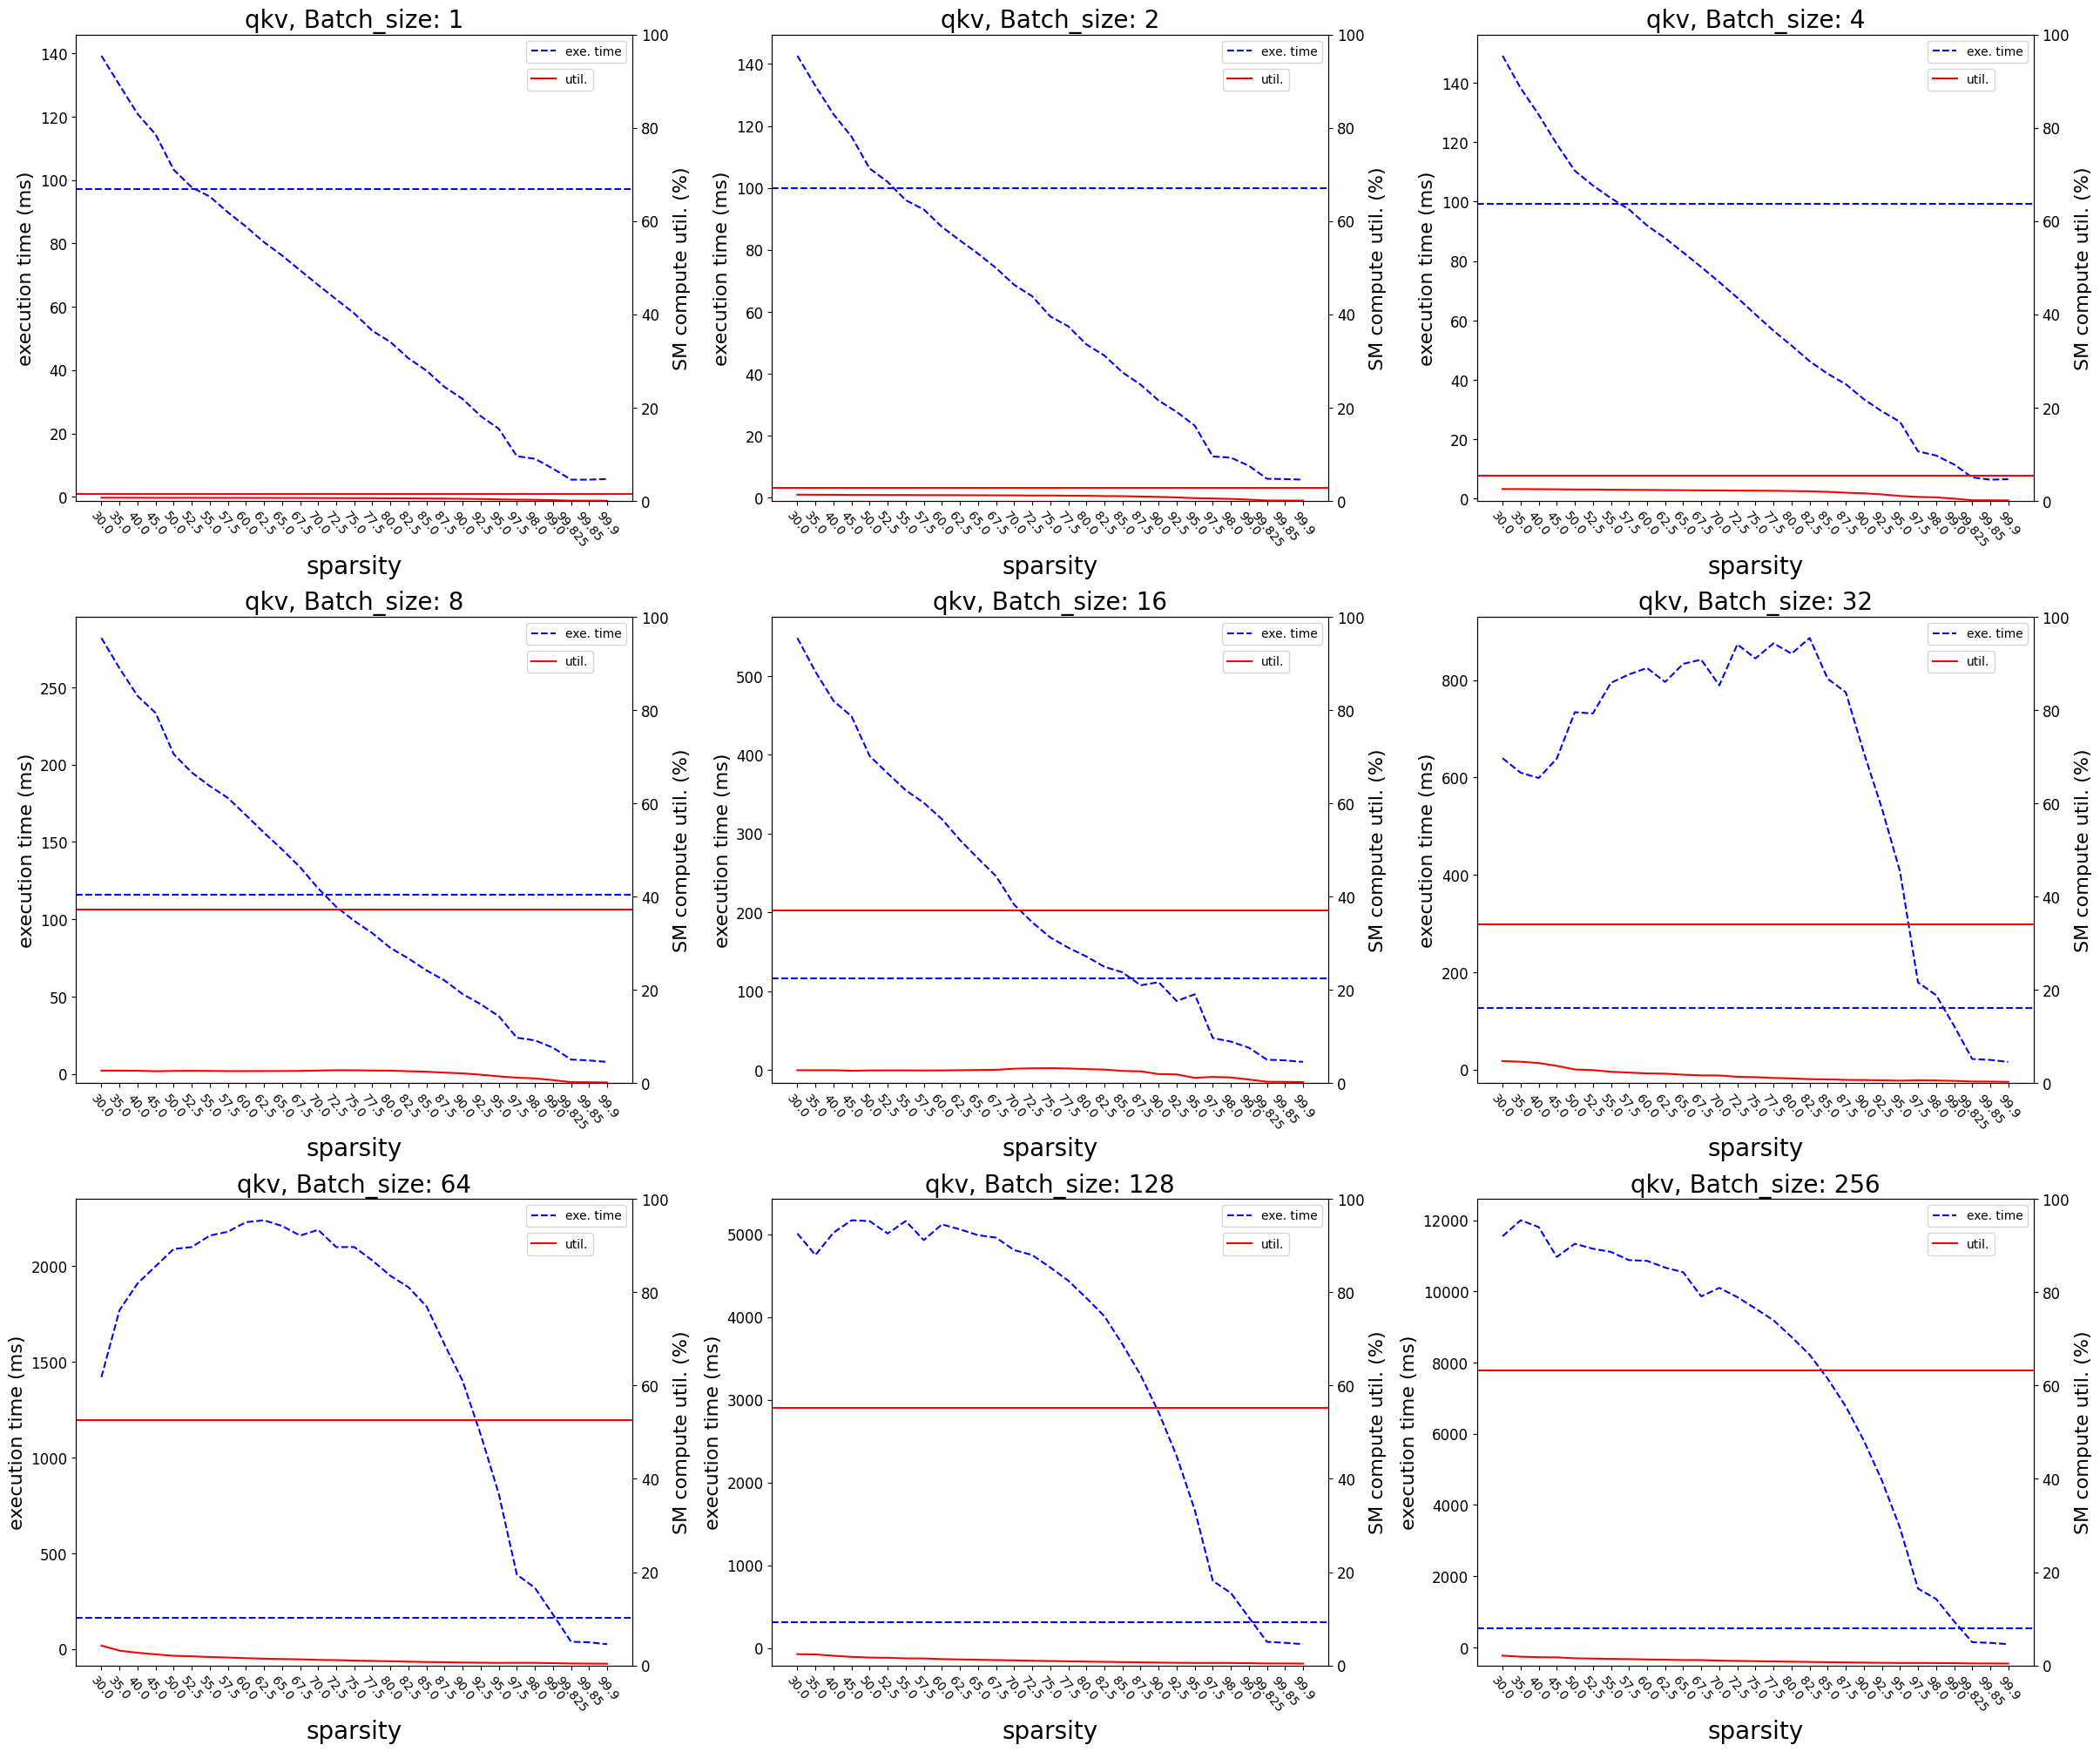

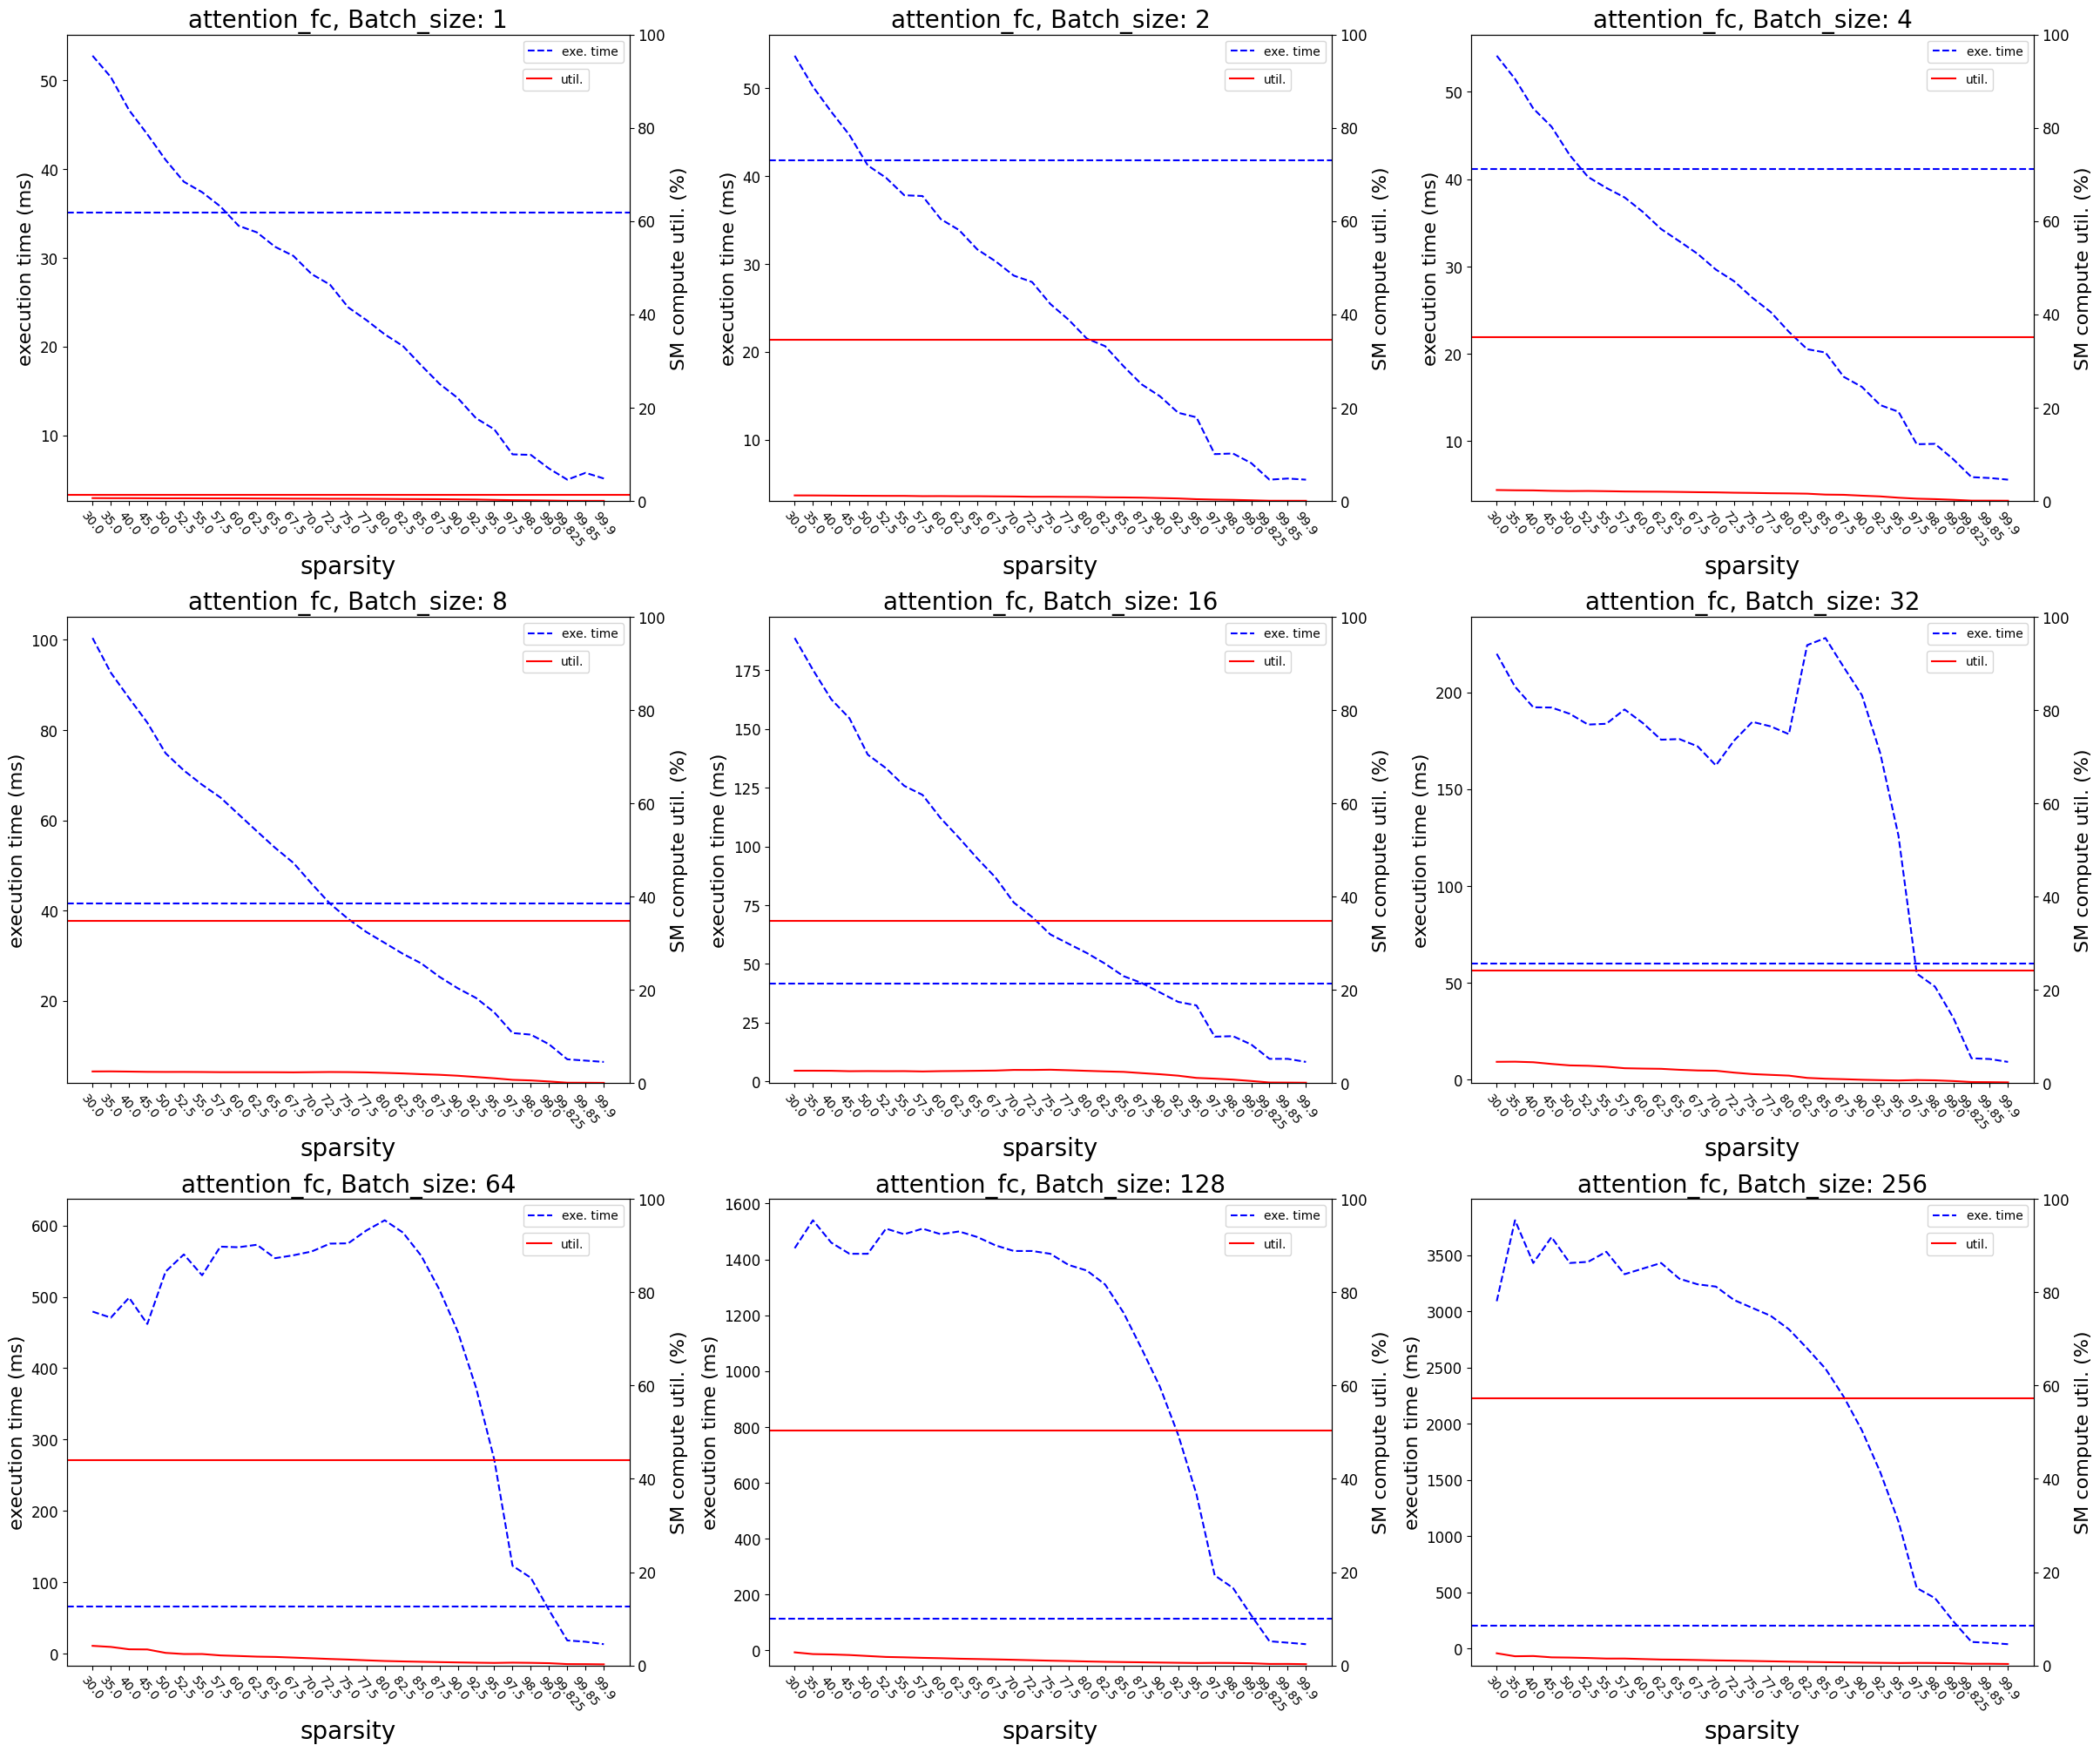

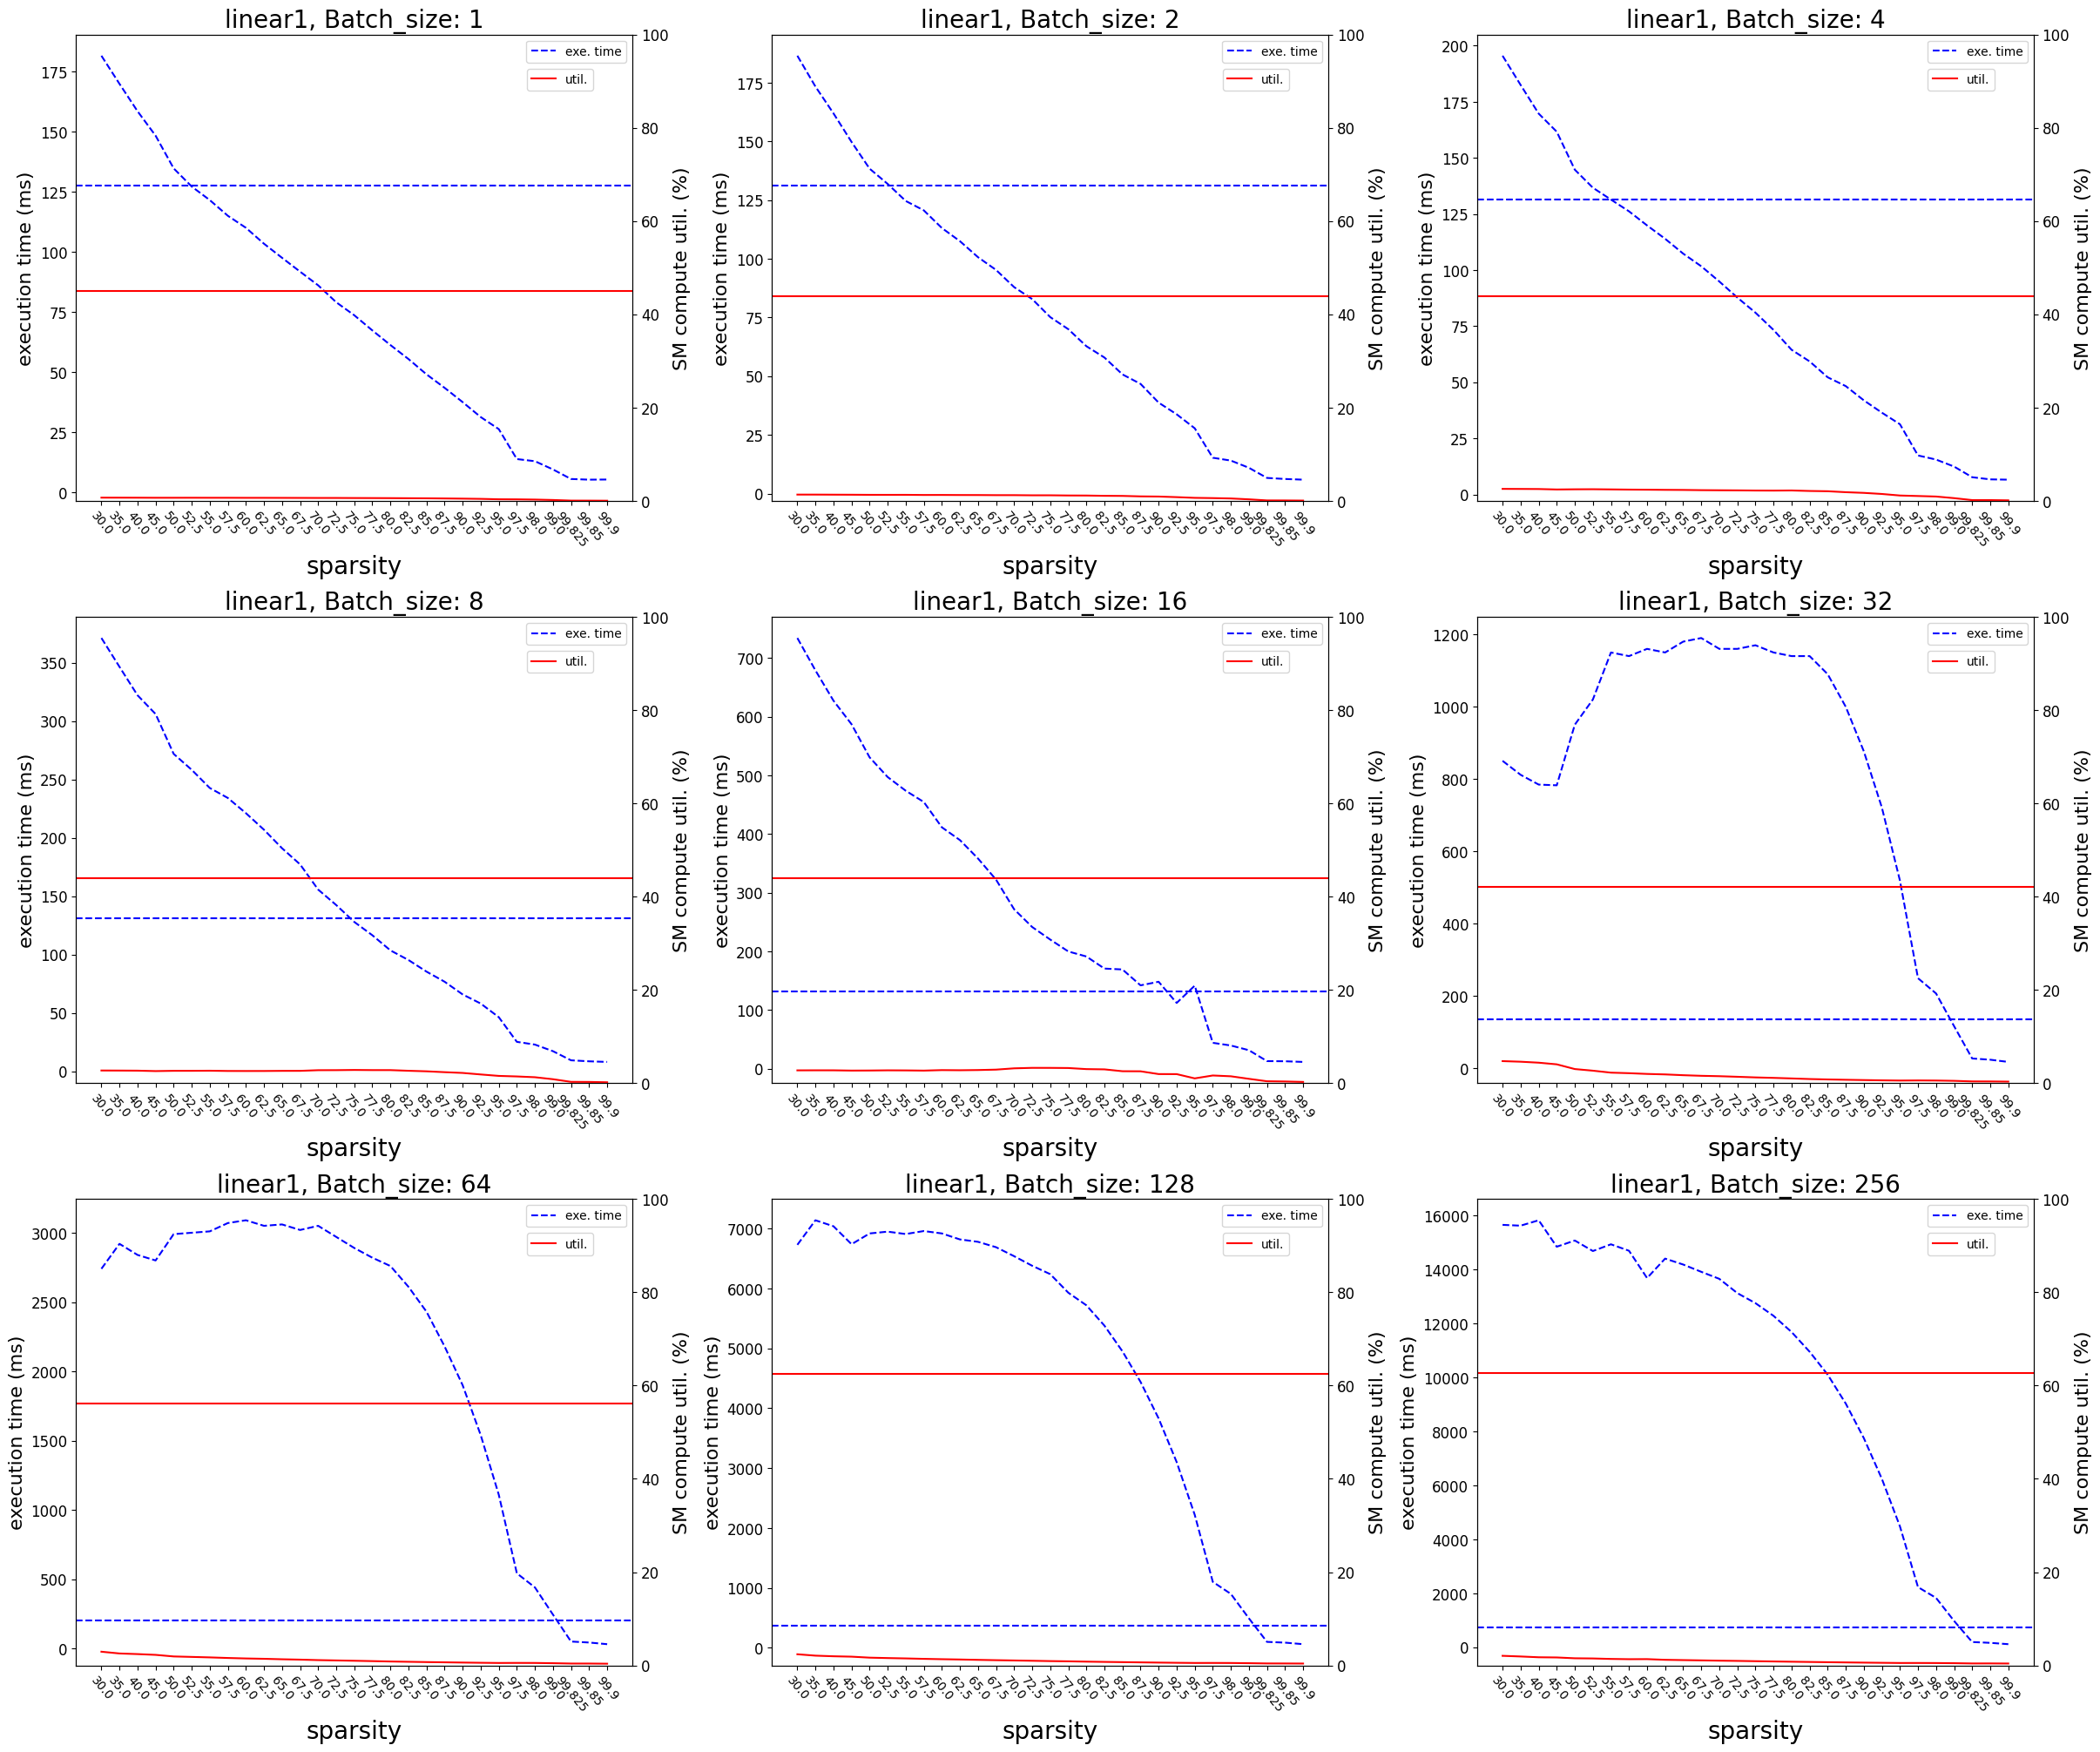

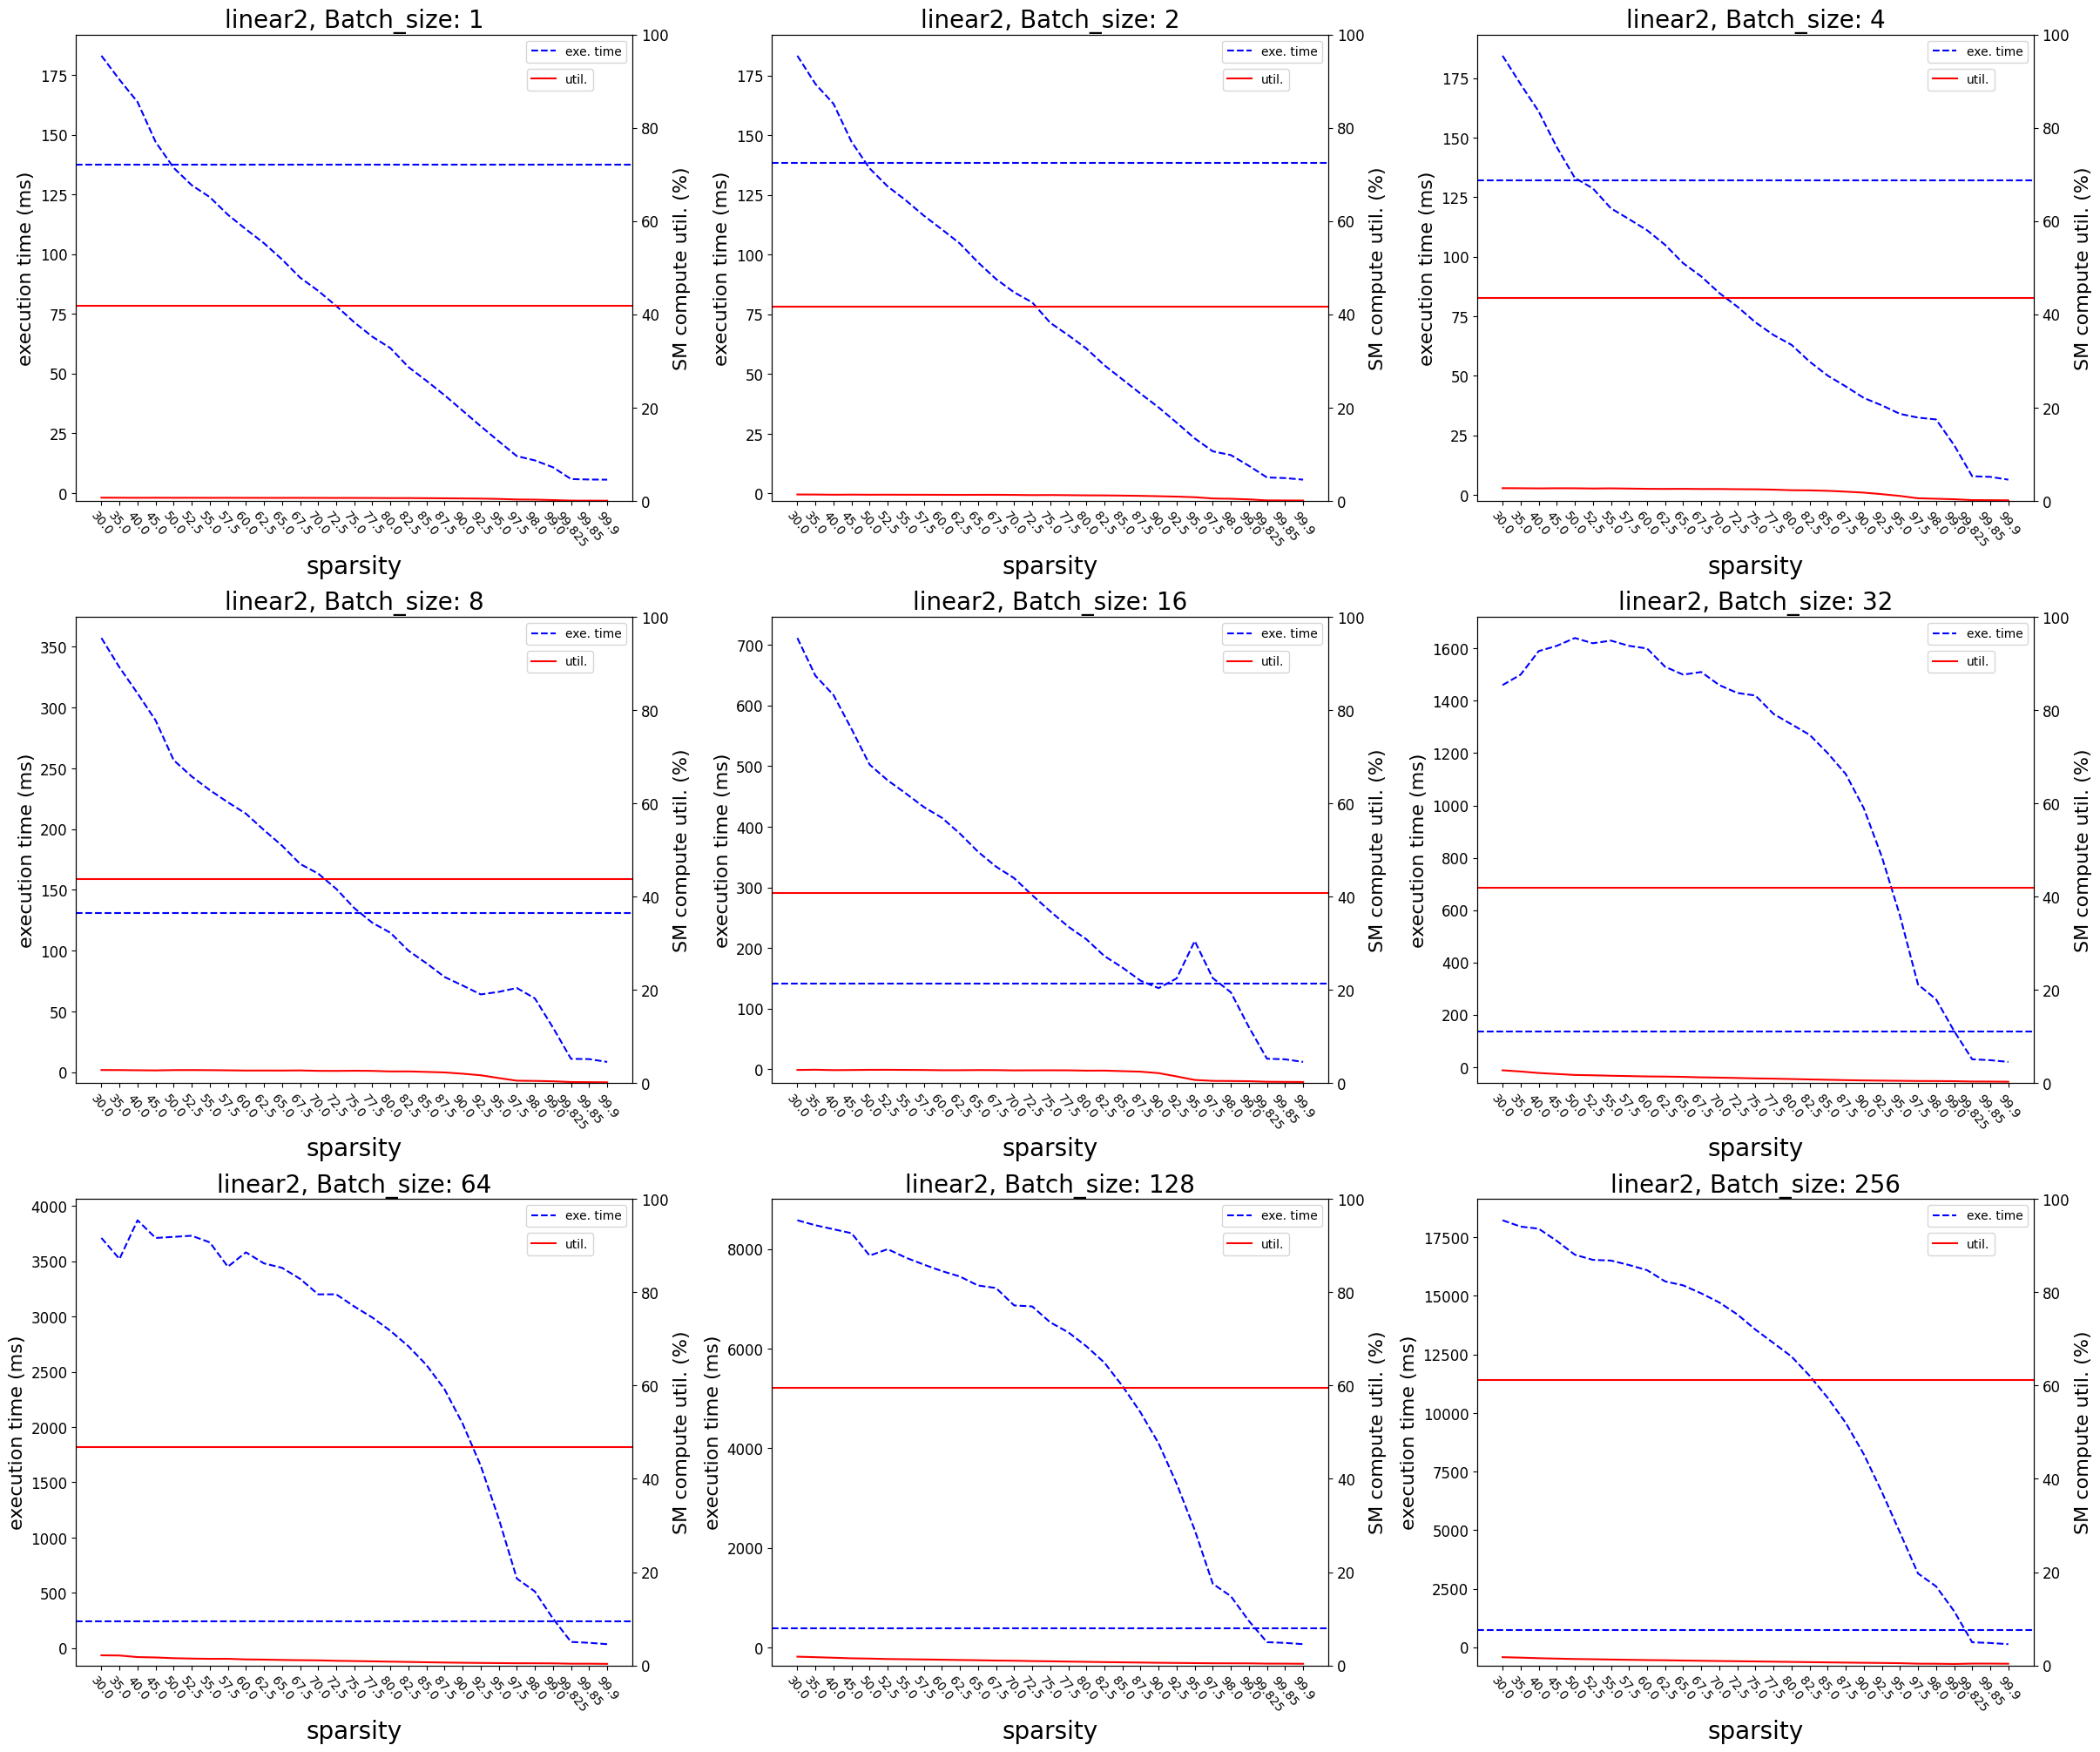

In [17]:
x = np.arange(len(sparsity))
for layer_type in problem:
    fig, axs = plt.subplots(3, 3, figsize=(24, 20),  constrained_layout=True)
    i = 0
    j = 0
    for batch in batch_size:
        baseline_time = baseline['time'][layer_type][batch]
        baseline_util = baseline['compute'][layer_type][batch]


        ax = axs[i, j]
        ax.plot(x, lat_data[layer_type][batch], color='blue', linestyle='--', label='exe. time') #marker='o'
        ax.axhline(y=baseline_time, linestyle='--', color='blue')
        
        ax2 = ax.twinx()
        ax2.plot(x, util_data[layer_type][batch], color='red', label="util.")
        ax2.axhline(y=baseline_util, color='red')

        ax.set_title(f"{layer_type}, Batch_size: {batch}", fontsize=20)
        ax.set_xticks(x, sparsity, rotation=-50, fontsize=10)
        ax.set_xlabel("sparsity", fontsize=20)
        ax.set_ylabel('execution time (ms)', fontsize=16)
        ax2.set_ylabel('SM compute util. (%)', fontsize=16)
        ax2.set_ylim(0,100)
        ax.tick_params(axis='y', labelsize=12)  
        ax2.tick_params(axis='y', labelsize=12)  

        ax.legend(loc='upper right')
        ax2.legend(loc=(0.81, 0.88))

        j += 1
        if j % 3 == 0:
            i += 1
            j = 0

In [48]:
for layer in problem:
    m, k = problem[layer]
    print("Profile: ",layer, m, k)
    for batch in batch_size:
        print("Batch_size:", m, batch, k)
        for sparse in density:
            print("Sparsity: , Density: ", round(1 - sparse,3), sparse)
            result = subprocess.run(f"CUDA_VISIBLE_DEVICES=1,2,3 ncu --print-summary per-kernel cusparse_sgemm {m} {batch} {k} {sparse} 5", stdout=subprocess.PIPE, shell=True)  
            idx = result.stdout.decode().find("CsrMMPolicy")
            idx_compute = result.stdout.decode()[idx:].find("sm__throughput.avg.pct_of_peak_sustained_elapsed") 
            idx_time = result.stdout.decode()[idx:].find("gpu__time_duration")
            compute = idx + idx_compute
            time = idx + idx_time 
            
            print(result.stdout.decode()[compute:compute+117].split())

            print(result.stdout.decode()[time:time+117].split())

            compute_util[layer][batch][sparse] = float(result.stdout.decode()[compute:compute+117].split()[-1])
            if result.stdout.decode()[time:time+120].split()[1] == 'msecond':
                execution_time[layer][batch][sparse] = float(result.stdout.decode()[time:time+117].split()[-1]) * 1000.0
            else:
                execution_time[layer][batch][sparse] = float(result.stdout.decode()[time:time+117].split()[-1])

Profile:  qkv 7680 2560
Batch_size: 7680 1 2560
Sparsity: , Density:  0.3 0.7
['sm__throughput.avg.pct_of_peak_sustained_elapsed', '%', '18.312711', '18.407371', '18.380754']
['gpu__time_duration.sum', 'usecond', '138.496000', '139.264000', '138.986667']
Sparsity: , Density:  0.35 0.65
['sm__throughput.avg.pct_of_peak_sustained_elapsed', '%', '18.320227', '18.415693', '18.364155']
['gpu__time_duration.sum', 'usecond', '130.240000', '130.624000', '130.437333']
Sparsity: , Density:  0.4 0.6
['sm__throughput.avg.pct_of_peak_sustained_elapsed', '%', '18.271754', '18.404464', '18.344710']
['gpu__time_duration.sum', 'usecond', '121.088000', '121.504000', '121.264000']
Sparsity: , Density:  0.45 0.55
['sm__throughput.avg.pct_of_peak_sustained_elapsed', '%', '18.165919', '18.188241', '18.175392']
['gpu__time_duration.sum', 'usecond', '113.696000', '114.688000', '114.074667']
Sparsity: , Density:  0.5 0.5
['sm__throughput.avg.pct_of_peak_sustained_elapsed', '%', '18.339068', '18.424638', '18.38

In [49]:
with open("./compute_util.json", 'w') as file:
    json.dump(compute_util, file)

with open("./latency.json", 'w') as file:
    json.dump(execution_time, file)